In [455]:
import os
import sys
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Compare baseline models

## Load global parameters

In [5]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [494]:
from pipelines.dataset_specific.baseline_config import DATA_PATH, MAIN_PATH, DATASETS, SCALERS

In [549]:
# TODO: hack
MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_diff'
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline'

In [550]:
MODELS = ['mlp-diff', 'naive']  # baseline models
# MODELS = ['mlp', 'naive']  # baseline models
INPUT_TYPES = ['supervised', 'sequential']
PLOT_PATH = MAIN_PATH / "plots"
PLOT_PATH.mkdir(parents=True, exist_ok=True)
# strip preprocessing info 
DATASETS = [d.split('_')[0] for d in DATASETS]

# Scalar heatmaps

## Load results

In [551]:
models_t = ['yhat', 'ynaive']
preds_t = ['trans', 'counts']
data_t = ['train', 'val']

In [552]:
data = {}
for path in (MAIN_PATH).iterdir():
    # ------ hack starts
    # 1) Select all data folders
    if path.name in ['plots', 'log', '.ipynb_checkpoints']:
        continue
    # 2) Scaler name may contain more than one word
    # Unfortunately, the same separator is used
    try:
        name = [path.name.replace(s, s.replace('_', '-')) for s in
                SCALERS if s in path.name][0]
    except:
        name = path.name
    # ------ hack ends
    elements = name.split('_')
    (model, input_type, scaler, train_dataset), preprocess = elements[:4], "_".join(elements[4:6])
    (overlap, shuffle), kwargs = elements[6:8], "_".join(elements[8:])
    overlap, shuffle = overlap.split('=')[-1], shuffle.split('=')[-1]
    if kwargs:
        kwargs += '_'
    name = f"{model}_{input_type}_{scaler}_{kwargs}_{train_dataset}_{overlap}_{shuffle}"
    for model_t in models_t:
        for pred_t in preds_t:
            for dat_t in data_t:
                pred_name = f"{pred_t}_{dat_t}_{model_t}"
                data[f"{name}_{pred_name}"] = json.load(open(MAIN_PATH / path.name / 'scores' / f'{pred_name}.json', 'r'))

## Create arrays

In [553]:
measures = ['Spearman mean', 'Spearman NaNs', 
            'NRMSE mean', 'NRMSE NaNs', 
            'Bray-Curtis mean', 'Procrustis']

# initialize arrays
arrays = {'trans': dict(zip(measures, [{} for i in range(len(measures))])),
          'counts': dict(zip(measures, [{} for i in range(len(measures))]))}
assert arrays.keys() == set(preds_t)

# overlap, shuffle combinations
ovshs = ['False_False', 'False_True', 'True_False', 'True_True']

# each measure computed as mean over bacteria
# the larger the better (in all cases)
# Spearman number of predicted:
#   - TOTAL - zero response from model or expected is zero (one of two vectors is constant)
# NRMSE total - false positives:
#   - TOTAL - nonzero response when we expect zeros (false positive)

for name in set(k.split('__')[0] for k in data.keys()):
    for pred_t in preds_t:
        for train_val in ['train', 'val']:
            # empty arrays
            tmp = dict(zip(arrays[pred_t].keys(), [np.empty([len(DATASETS), len(ovshs)], dtype=object) 
                                           for i in range(len(arrays[pred_t]))]))
            for i, d in enumerate(DATASETS):
                for j, ovsh in enumerate(ovshs):
                    # model prediction
                    datum_m = data[f"{name}__{d}_{ovsh}_{pred_t}_{train_val}_yhat"]
                    # reference prediction
                    datum_r = data[f"{name}__{d}_{ovsh}_{pred_t}_{train_val}_ynaive"]
                    tmp['Spearman mean'][i, j] = (datum_m['spearman'][0], 
                                                  datum_m['spearman'][0] - datum_r['spearman'][0],
                                                  datum_m['spearman'][1])
                    tmp['Spearman NaNs'][i, j] = (datum_m['spearman'][2],
                                                  -(datum_m['spearman'][2] - datum_r['spearman'][2]))  # negative !!!
                    tmp['NRMSE mean'][i, j] = (datum_m['nrmse'][0],
                                               -(datum_m['nrmse'][0] - datum_r['nrmse'][0]),   # negative !!!
                                               datum_m['nrmse'][1])
                    tmp['NRMSE NaNs'][i, j] = (datum_m['nrmse'][2],
                                               -(datum_m['nrmse'][2] - datum_r['nrmse'][2]))  # negative !!!
                    tmp['Bray-Curtis mean'][i, j] = (1 - datum_m['inter'][0],
                                                     -(datum_m['inter'][0] - datum_r['inter'][0]),  # netative !!!
                                                     datum_m['inter'][1])
                    tmp['Procrustis'][i, j] = (1 - datum_m['intra'],
                                               -(datum_m['intra'] - datum_r['intra']))  # negative !!!
            # array
            name_full = f"{name}_{train_val}"
            arrays[pred_t]['Spearman mean'][name_full] = tmp['Spearman mean'] 
            arrays[pred_t]['Spearman NaNs'][name_full] = tmp['Spearman NaNs'] 
            arrays[pred_t]['NRMSE mean'][name_full] = tmp['NRMSE mean'] 
            arrays[pred_t]['NRMSE NaNs'][name_full] = tmp['NRMSE NaNs'] 
            arrays[pred_t]['Bray-Curtis mean'][name_full] = tmp['Bray-Curtis mean'] 
            arrays[pred_t]['Procrustis'][name_full] = tmp['Procrustis'] 

In [554]:
kwargs = {'cmap': "coolwarm", 'linewidth': 0.5,
          'xticklabels': ovshs,
          'yticklabels': DATASETS,
         }
plot_params = {'Spearman mean': {'label': 'Spearman coefficient', 'vmin': -1, 'vmax': 1},
               'NRMSE mean': {'label': 'NRMSE', 'vmin': 'computed', 'vmax': 'computed'},
               'Spearman NaNs': {'label': 'Spearman total - (false positives + false negatives)', 'vmin': 'computed', 'vmax': 'computed'},
               'NRMSE NaNs': {'label': 'NRMSE total - false positives', 'vmin': 'computed', 'vmax': 'computed'},
               'Bray-Curtis mean': {'label': 'Bray-Curtis similarity', 'vmin': -1, 'vmax': 1},
               'Procrustis': {'label': 'Procrustis similarity', 'vmin': -1, 'vmax': 1},
         }

In [555]:
def merge_str_arr(mean_, diff_, std_=None):
    arr1 = np.char.mod('%.2f', mean_)
    arr2 = np.char.mod(' / %.2f', diff_)
    if std_ is not None:
        arr3 = np.char.mod(' / %.1f', std_)
        return np.char.add(arr1, np.char.add(arr2, arr3))
    else:
        return np.char.add(arr1, arr2)

def get_attr_from_measure(arr, ind):
    return np.array([y[ind] for x in arr for y in x]).reshape(arr.shape)

### Example

- color: `mean_model - mean_reference
- text: `mean_model - mean_reference (std_model)

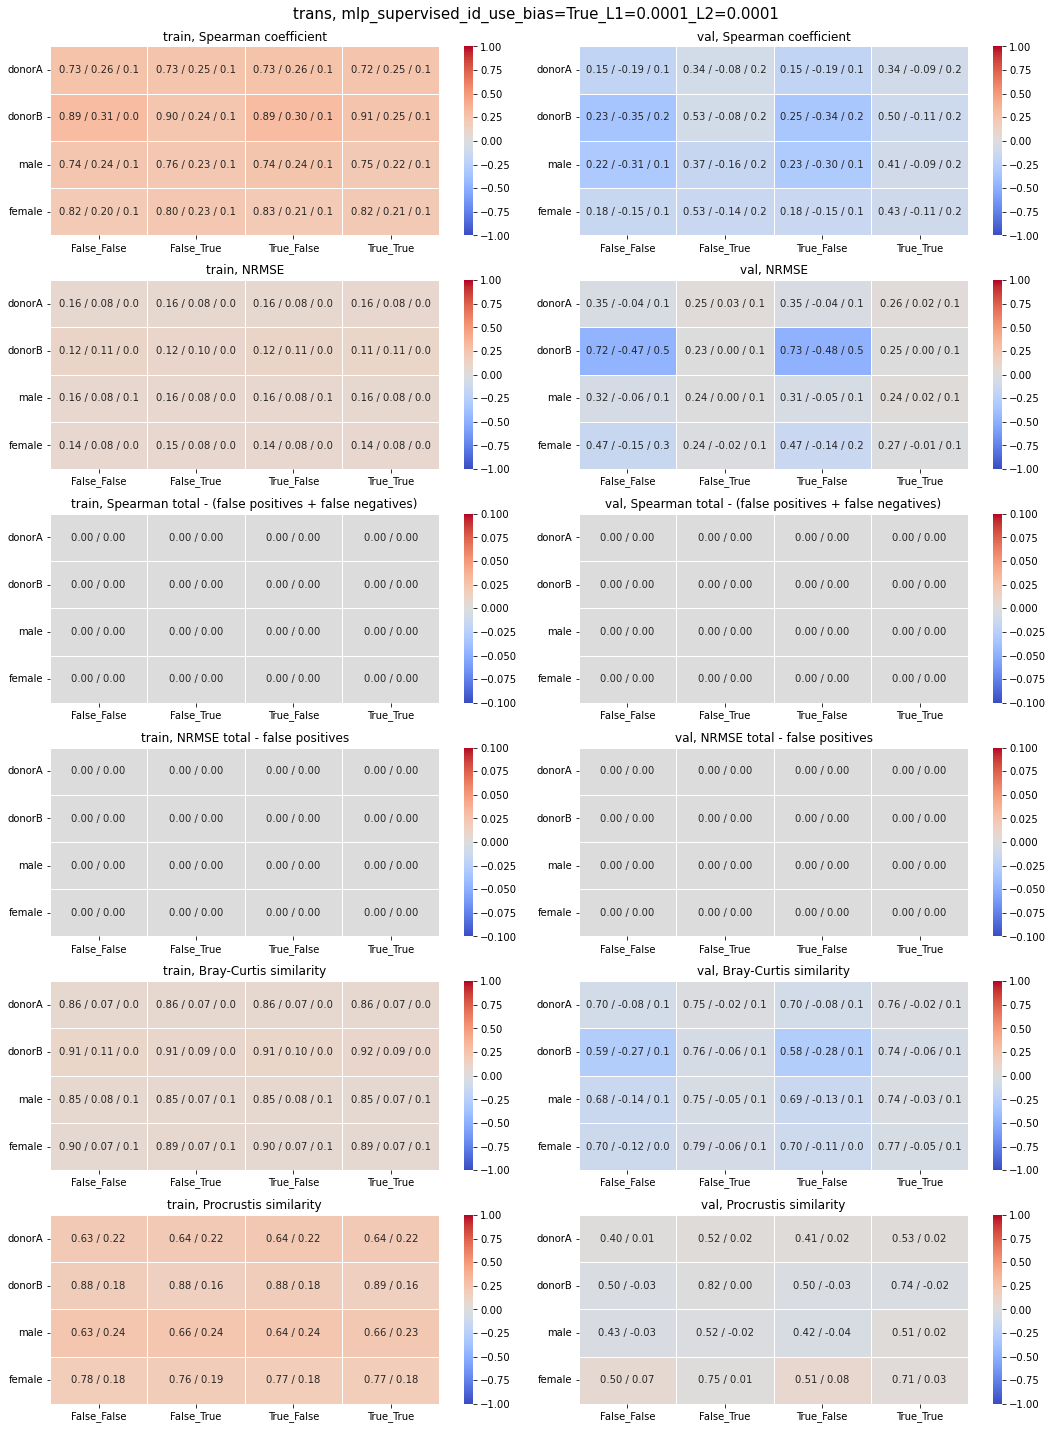

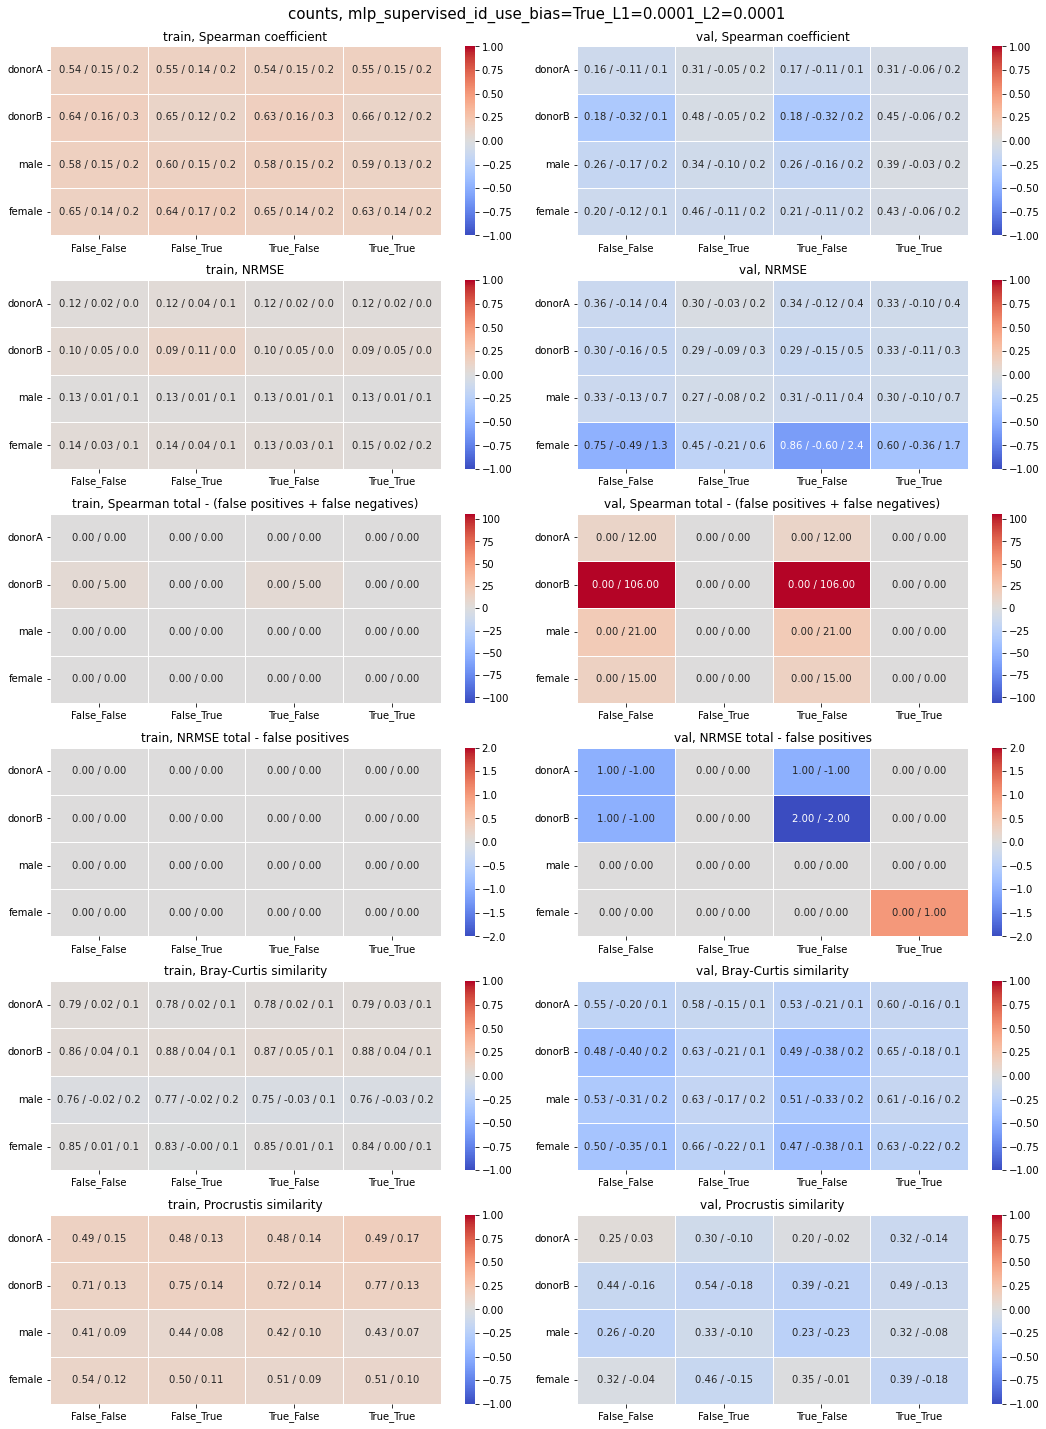

In [508]:
# name = 'mlp-diff_supervised_id_use_bias=True_L1=0.0001_L2=0.0001'
name = 'mlp-diff_sequential_id_use_input_bias=True_use_pred_bias=True_input_L1=0.001_input_L2=0.001_pred_L1=0_pred_L2=0'
# name = 'mlp_supervised_id_use_bias=True_L1=0.0001_L2=0.0001'
# name = 'mlp_sequential_id_use_input_bias=True_use_pred_bias=True_input_L1=0.001_input_L2=0.001_pred_L1=0_pred_L2=0'
for pred_t in preds_t:
    plt.figure(figsize=(15, 20))
    for i, (k, v) in enumerate(plot_params.items()):
        plt.subplot(len(plot_params), 2, 2*i+1)
        # NRMSE mean / NaNs can be very different
        train_mean = get_attr_from_measure(arrays[pred_t][k][f'{name}_train'], 0)
        val_mean = get_attr_from_measure(arrays[pred_t][k][f'{name}_val'], 0)
        train_diff = get_attr_from_measure(arrays[pred_t][k][f'{name}_train'], 1)
        val_diff = get_attr_from_measure(arrays[pred_t][k][f'{name}_val'], 1)
        merged = np.concatenate([train_diff, val_diff])
        if v['vmax'] == 'computed' and v['vmin'] == 'computed':
            max_ = np.ceil(np.max(abs(merged)))
            vmax, vmin = max_, -max_
        else:
            vmax, vmin = v['vmax'], v['vmin']        
        if 'mean' in k:
            train_std = get_attr_from_measure(arrays[pred_t][k][f'{name}_train'], 2)
            val_std = get_attr_from_measure(arrays[pred_t][k][f'{name}_val'], 2)
            annot_train = merge_str_arr(train_mean, train_diff, train_std)
            annot_val = merge_str_arr(val_mean, val_diff, val_std)
        else:
            annot_train = merge_str_arr(train_mean, train_diff)
            annot_val = merge_str_arr(val_mean, val_diff)
        ax = sns.heatmap(train_diff, annot=annot_train, vmin=vmin, vmax=vmax,  fmt='', **kwargs)
        ax.tick_params(axis='y', rotation=0)
        ax.set_title(f'train, {v["label"]}')
        plt.subplot(len(plot_params), 2, 2*i+2)
        ax = sns.heatmap(val_diff, annot=annot_val, vmin=vmin, vmax=vmax,  fmt='', **kwargs)
        ax.tick_params(axis='y', rotation=0)
        ax.set_title(f'val, {v["label"]}')
    plt.suptitle(f"{pred_t}, {name}", fontsize=15, y=0.99)
    plt.tight_layout()
    plt.savefig(PLOT_PATH / f"{pred_t}_{name}.png", dpi=200, facecolor='white')
    plt.show()

### Loop

In [509]:
names = set(k.split('__')[0] for k in data.keys())
for count, name in enumerate(names):
    for pred_t in preds_t:
        plt.figure(figsize=(15, 20))
        for i, (k, v) in enumerate(plot_params.items()):
            plt.subplot(len(plot_params), 2, 2*i+1)
            # NRMSE mean / NaNs can be very different
            train_mean = get_attr_from_measure(arrays[pred_t][k][f'{name}_train'], 0)
            val_mean = get_attr_from_measure(arrays[pred_t][k][f'{name}_val'], 0)
            train_diff = get_attr_from_measure(arrays[pred_t][k][f'{name}_train'], 1)
            val_diff = get_attr_from_measure(arrays[pred_t][k][f'{name}_val'], 1)
            merged = np.concatenate([train_diff, val_diff])
            if v['vmax'] == 'computed' and v['vmin'] == 'computed':
                max_ = np.ceil(np.max(abs(merged)))
                vmax, vmin = max_, -max_
            else:
                vmax, vmin = v['vmax'], v['vmin']        
            if 'mean' in k:
                train_std = get_attr_from_measure(arrays[pred_t][k][f'{name}_train'], 2)
                val_std = get_attr_from_measure(arrays[pred_t][k][f'{name}_val'], 2)
                annot_train = merge_str_arr(train_mean, train_diff, train_std)
                annot_val = merge_str_arr(val_mean, val_diff, val_std)
            else:
                annot_train = merge_str_arr(train_mean, train_diff)
                annot_val = merge_str_arr(val_mean, val_diff)
            ax = sns.heatmap(train_diff, annot=annot_train, vmin=vmin, vmax=vmax,  fmt='', **kwargs)
            ax.tick_params(axis='y', rotation=0)
            ax.set_title(f'train, {v["label"]}')
            plt.subplot(len(plot_params), 2, 2*i+2)
            ax = sns.heatmap(val_diff, annot=annot_val, vmin=vmin, vmax=vmax,  fmt='', **kwargs)
            ax.tick_params(axis='y', rotation=0)
            ax.set_title(f'val, {v["label"]}')
        plt.suptitle(f"{pred_t}, {name}", fontsize=15, y=0.99)
        plt.tight_layout()
        plt.savefig(PLOT_PATH / f"{pred_t}_{name}.png", dpi=200, facecolor='white')
        plt.close()
    print(f"Done: {count+1} / {len(names)}", end='\r')

# Vector plots

Analyse specific combinations deeper, looking at change in scores:
- over time (`f1_score`, `inter`) 
- over bacteria (`Spearman`, `NRMSE`)

In [556]:
# model
mname = 'mlp-diff'
# mname = 'mlp'
intype = 'sequential'
kwargs = 'use_input_bias=True_use_pred_bias=True_input_L1=0.001_input_L2=0.001_pred_L1=0_pred_L2=0'

overlap, shuffle = True, False
pred_type = 'trans'
score = 'nrmse'  # score we want to analyse
scaler = 'id'
preprocess = 'filtered-0.9_clr-1'
mname_full = f"{mname}_{intype}_id_TRAINSET_filtered-0.9_clr-1-True_overlap={overlap}_shuffle={shuffle}"
# NOTE: CHANGE IF SCORES HAVE CHANGED
xlabel = 'bacteria (index)' if score in ['nrmse', 'spearman'] else 'timestep (index)'

### Load data

In [557]:
data_vec = {}
data_ref_vec = {}
for d in DATASETS:
    model_path = MAIN_PATH / f"{mname_full.replace('TRAINSET', d)}_{kwargs}" / "scores"
    data_vec[f"{d}_train"] = pd.read_csv(model_path / f'{pred_type}_train_yhat_{score}.csv', index_col=0)
    data_vec[f"{d}_val"] = pd.read_csv(model_path / f'{pred_type}_val_yhat_{score}.csv', index_col=0)
    data_ref_vec[f"{d}_train"] = pd.read_csv(model_path / f'{pred_type}_train_ynaive_{score}.csv', index_col=0)
    data_ref_vec[f"{d}_val"] = pd.read_csv(model_path / f'{pred_type}_val_ynaive_{score}.csv', index_col=0)

In [558]:
assert data_vec.keys() == data_ref_vec.keys()

## Plots

Doc: https://plotly.com/python/subplots/

In [516]:
import plotly
import plotly.graph_objects as go

from IPython.display import IFrame
from plotly.subplots import make_subplots

In [517]:
fig = make_subplots(rows=1, cols=2, x_title=xlabel, y_title='model - reference',
                    subplot_titles=[f"{score}, train", f"{score}, validation"])
# take difference wrt the reference (naive)
# train / val
for d in DATASETS:
    tmp_t = data_vec[f"{d}_train"] -  data_ref_vec[f"{d}_train"]
    fig.add_trace(go.Scatter(y=tmp_t.values[:,0], name=f"{d}: {tmp_t.mean()[0]:.2f}"), row=1, col=1)
# val
for d in DATASETS:
    tmp_v = data_vec[f"{d}_val"] -  data_ref_vec[f"{d}_val"]
    fig.add_trace(go.Scatter(y=tmp_v.values[:,0], name=f"{d}: {tmp_v.mean()[0]:.2f}"), row=1, col=2)
fig.update_layout(showlegend=True, font=dict(size=8),
                  title_text=f"<b>Model:</b> {mname_full}<br>{kwargs}<br><b>Reference:</b> naive")
plotly.offline.plot(fig, filename = f"{PLOT_PATH}/vector_{pred_type}_{score}_{mname_full}_{kwargs}.html", auto_open=False)
IFrame(src=f"{os.path.relpath(PLOT_PATH)}/vector_{pred_type}_{score}_{mname_full}_{kwargs}.html", width=1000, height=400)

# Predictions

See raw predictions for specifc model and bacteria

**Note:** 
- if `shuffle=True` timesteps order may be random

### Load data

In [559]:
preds = {}
for d in DATASETS:
    model_path = MAIN_PATH / f"{mname_full.replace('TRAINSET', d)}_{kwargs}" / "scores"
    preds[d]= np.load(model_path.parents[0] /  f'train_val_predictions.npz')

## Plots

### Matplotlib

In [560]:
dataset = 'donorA'
bact = 0 # bacterium index

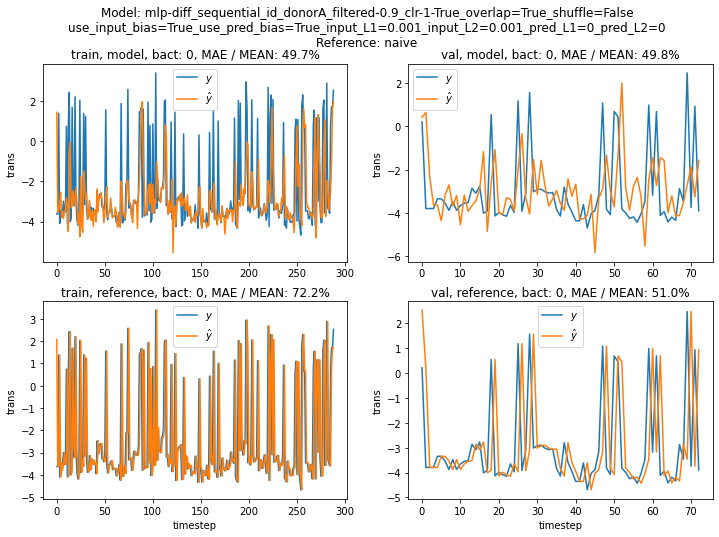

In [561]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(['train', 'val']):
    ax = plt.subplot(2, 2, i+1)
    y = preds[dataset][f'{pred_type}_{label}_y'][:, bact]
    yhat = preds[dataset][f'{pred_type}_{label}_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / abs(y.mean()) * 100
    # error2 = abs((y-yhat) / y * 100).mean()  # may explode if y = 0
    ax.plot(y, label=r'$y$')
    ax.plot(yhat, label=r'$\hat{y}$')
    ax.set(title=f'{label}, model, bact: {bact}, MAE / MEAN: {error:.1f}%', ylabel=pred_type)
    ax.legend()
for i, label in enumerate(['train', 'val']):
    ax = plt.subplot(2, 2, i+3)
    y = preds[dataset][f'{pred_type}_{label}_y'][:, bact]
    yhat = preds[dataset][f'{pred_type}_{label}_ynaive'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / abs(y.mean()) * 100
    # error2 = abs((y-yhat) / y * 100).mean()  # may explode if y = 0
    ax.plot(y, label=r'$y$')
    ax.plot(yhat, label=r'$\hat{y}$')
    ax.set(title=f'{label}, reference, bact: {bact}, MAE / MEAN: {error:.1f}%', 
           xlabel='timestep', ylabel=pred_type)
    ax.legend()
plt.suptitle(f"Model: {mname_full.replace('TRAINSET',dataset)}\n{kwargs}\nReference: naive")
plt.savefig(PLOT_PATH / f"pred_train_{pred_type}_{score}_bact_{bact}_{mname_full.replace('TRAINSET',dataset)}_{kwargs}.png", dpi=200, facecolor='white')
plt.show()

### Plotly
Doc: https://plotly.com/python/subplots/

In [562]:
fig = make_subplots(rows=2, cols=2, x_title='timestep', y_title=pred_type,
                    subplot_titles=[f"train, model, bact: {bact}",
                                    f"val, model, bact: {bact}",
                                    f"train, reference, bact: {bact}",
                                    f"val, reference, bact: {bact}"])
# train/val, model
for i, label in enumerate(['train', 'val']):
    y = preds[dataset][f'{pred_type}_{label}_y'][:, bact]
    yhat = preds[dataset][f'{pred_type}_{label}_yhat'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / abs(y.mean()) * 100
    fig.add_trace(go.Scatter(y=y, name=f"y"), row=1, col=i+1)
    fig.add_trace(go.Scatter(y=yhat, name=f"yhat, {error:.1f}%"), row=1, col=i+1)
# train/val, reference
for i, label in enumerate(['train', 'val']):
    y = preds[dataset][f'{pred_type}_{label}_y'][:, bact]
    yhat = preds[dataset][f'{pred_type}_{label}_ynaive'][:, bact]
    error = sum(abs(y - yhat)) / len(y) / abs(y.mean()) * 100
    fig.add_trace(go.Scatter(y=y, name=f"y"), row=2, col=i+1)
    fig.add_trace(go.Scatter(y=yhat, name=f"yhat, {error:.1f}%"), row=2, col=i+1)
fig.update_layout(showlegend=True, font=dict(size=8),
                  title_text=f"<b>Model:</b> {mname_full.replace('TRAINSET',dataset)}<br>{kwargs}<br><b>Reference:</b> naive")
plotly.offline.plot(fig, filename = f"{PLOT_PATH}/pred_train_{pred_type}_{score}_bact_{bact}_{mname_full.replace('TRAINSET',dataset)}_{kwargs}.html", auto_open=False)
IFrame(src=f"{os.path.relpath(PLOT_PATH)}/pred_train_{pred_type}_{score}_bact_{bact}_{mname_full.replace('TRAINSET',dataset)}_{kwargs}.html", width=1000, height=500)

# Difference comparison
Compare two differences:
- model prediction vs true against
- reference prediction vs true

How often model's predictions are closer to true than the reference ones?

In [563]:
def compare_differences(preds, dataset, pred_type, train_val, threshold=0.1):
    diffs, M1, M2, M3 = [], [], [], []
    INPUT_FEATURES = preds[dataset][f'{pred_type}_{train_val}_y'].shape[1]
    for bacterium in range(INPUT_FEATURES):
        diffs_bact = []  # differences
        M1_bact = []  # model fails
        M2_bact = []  # reference fails
        M3_bact = []  # both fails/wins
        y = preds[dataset][f'{pred_type}_{train_val}_y'][:, bacterium]
        yhat = preds[dataset][f'{pred_type}_{train_val}_yhat'][:, bacterium]
        yhat_ref = preds[dataset][f'{pred_type}_{train_val}_ynaive'][:, bacterium]
        for i in range(len(y)):
            diff = y[i] - yhat[i]
            diff_ref = y[i] - yhat_ref[i]
            # round predictions around zero
            # TODO round all values?
            diff = 0 if abs(diff) <= threshold else diff
            diff_ref = 0 if abs(diff_ref) < threshold else diff_ref
            # model fails
            if diff_ref == 0 and diff != 0:
                M1_bact.append(abs(diff) / np.mean(y))  # TODO: improve normalization?
            # reference fails
            elif diff == 0 and diff_ref != 0:
                M2_bact.append(abs(diff_ref) / np.mean(y))  # TODO: improve normalization?
            # both wins
            elif diff_ref == 0 and diff == 0:
                M3_bact.append(1)
            # both fails
            else:
                M3_bact.append(abs(diff / diff_ref))
            diffs_bact.append((diff, diff_ref))
        diffs.append(diffs_bact)
        M1.append(M1_bact)
        M2.append(M2_bact)
        M3.append(M3_bact)
    return diffs, M1, M2, M3

In [564]:
pred_type = 'trans'

In [565]:
diffs, M1, M2, M3 = {}, {}, {}, {}
for d in DATASETS:
    for train_val in ['train', 'val']:
        diffs[f"{d}_{train_val}"], M1[f"{d}_{train_val}"], M2[f"{d}_{train_val}"], M3[f"{d}_{train_val}"] =\
        compare_differences(preds, d, pred_type, train_val)

### Number of model / referenece wins across bacteria

In [566]:
total_steps = {}
for train_val in ['train', 'val']:
    for d in DATASETS:
        total_steps[f"{d}_{train_val}"] = preds[d][f'{pred_type}_{train_val}_y'].shape[0]

In [567]:
model_minus_reference_wins = {}
for d in DATASETS:
    for train_val in ['train', 'val']:
        model_minus_reference_wins[f"{d}_{train_val}"] = []
        for bacterium in range(len(M1[f"{d}_{train_val}"])):
            model_wins = sum(1 if el < 1 else 0 for el in M3[f"{d}_{train_val}"][bacterium]) + len(M2[f"{d}_{train_val}"][bacterium])
            ref_wins = sum(1 if el > 1 else 0 for el in M3[f"{d}_{train_val}"][bacterium]) + len(M1[f"{d}_{train_val}"][bacterium])
            # model_minus_reference_wins[f"{d}_{train_val}"].append(model_wins - ref_wins)
            # Normalized
            model_minus_reference_wins[f"{d}_{train_val}"].append((model_wins - ref_wins) / total_steps[f"{d}_{train_val}"] * 100)

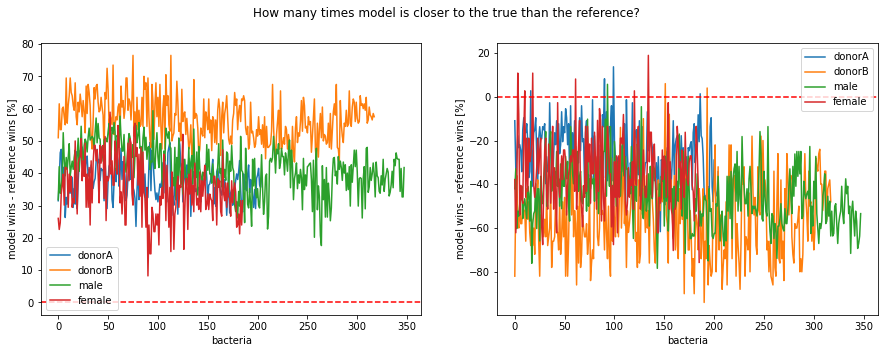

In [568]:
plt.figure(figsize=(15, 5))
for i, train_val in enumerate(['train', 'val']):
    plt.subplot(1, 2, i+1)
    for d in DATASETS:
        plt.plot(range(len(model_minus_reference_wins[f"{d}_{train_val}"])), 
                 model_minus_reference_wins[f"{d}_{train_val}"], label=d)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylabel('model wins - reference wins [%]')
    plt.xlabel('bacteria')
    plt.legend()
plt.suptitle('How many times model is closer to the true than the reference?')
plt.savefig(f"{PLOT_PATH}/wins_{pred_type}_{mname_full}_{kwargs}.png", dpi=200)
plt.show()

### For specific dataset & bacterium

In [575]:
d = 'donorB'
bact = 0

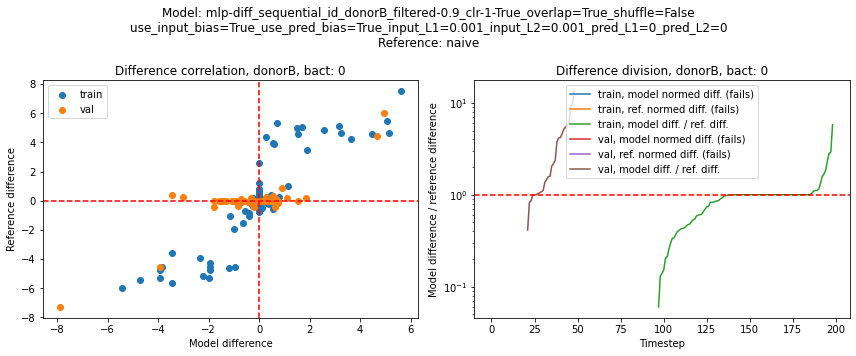

In [576]:
plt.figure(figsize=(12, 5))
plt.suptitle(f"Model: {mname_full.replace('TRAINSET', d)}\n{kwargs}\nReference: naive")
plt.subplot(1, 2, 1)
for train_val in ['train', 'val']:
    plt.scatter([el[0] for el in diffs[f"{d}_{train_val}"][bact]], 
                [el[1] for el in diffs[f"{d}_{train_val}"][bact]], label=train_val)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.legend()
plt.title(f'Difference correlation, {d}, bact: {bact}')
plt.xlabel('Model difference')
plt.ylabel('Reference difference')
plt.subplot(1, 2, 2)
for train_val in ['train', 'val']:
    d_tv = f"{d}_{train_val}"
    plt.plot(range(len(M1[d_tv][bact])), sorted(M1[d_tv][bact]), label=f'{train_val}, model normed diff. (fails)')
    plt.plot(range(len(M1[d_tv][bact])-1, len(M1[d_tv][bact])+len(M2[d_tv][bact])-1), 
             sorted(M2[d_tv][bact]), label=f'{train_val}, ref. normed diff. (fails)')
    plt.plot(range(len(M1[d_tv][bact])+len(M2[d_tv][bact])-1, 
                   len(M1[d_tv][bact])+len(M2[d_tv][bact])+len(M3[d_tv][bact])-1), sorted(M3[d_tv][bact]),
             label=f'{train_val}, model diff. / ref. diff.')
plt.axhline(y=1, color='r', linestyle='--')
plt.yscale('log')
plt.title(f'Difference division, {d}, bact: {bact}')
plt.xlabel('Timestep')
plt.ylabel('Model difference / reference difference')
plt.legend()
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/wins_{pred_type}_bact_{bact}_{mname_full.replace('TRAINSET', d)}_{kwargs}.png", dpi=200)
plt.show()